<a href="https://colab.research.google.com/github/SunitSoni/Automated-Football-Player-Detection-and-Offside-Decision-Analysis-Using-Computer-Vision/blob/main/Automated_Football_Player_Detection_and_Offside_Decision_Analysis_Using_Deep_Learning_and_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the environment

In [ ]:
!nvidia-smi

Mon Apr 28 17:53:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install "rich~=13.0.0"

In [ ]:
!pip install "inference[transformers,sam,clip,gaze,grounding-dino,yolo-world]"

In [ ]:
!pip install pymc inference-gpu supervision

In [ ]:
# !pip install -q git+https://github.com/roboflow/sports.git

In [ ]:
# !gdown -O "video_1.mp4" "https://drive.google.com/file/d/1woQnc4WnCc4oQgy18v4PqvrYvPmvKnF8/view?t=3"

In [ ]:
# !pip install -q gdown inference-gpu supervision
# !pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

In [ ]:
# !pip uninstall -y supervision && pip install -q supervision>0.23.0

In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Detection

In [ ]:
from inference import get_model
from google.colab import userdata

roboflow_api_key = userdata.get('roboflow_api_key')
detection_model_id = "football-players-detection-3zvbc/12"
detection_model = get_model(model_id = detection_model_id, api_key = roboflow_api_key)

In [ ]:
import supervision as sv
import cv2
import numpy as np

In [ ]:
# Paths for input and output videos
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Colab_Notebooks/IDP/video_4.mp4"
OUTPUT_VIDEO_PATH = "/content/annotated_video.mp4"
BALL_ID = 0

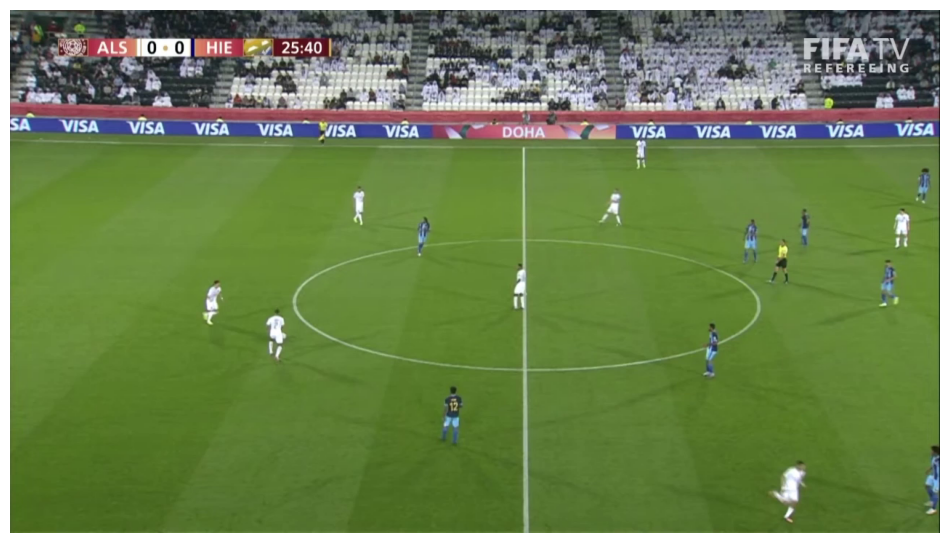

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [ ]:
# Creating annotators
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

In [ ]:
# Open the source video
video = cv2.VideoCapture(SOURCE_VIDEO_PATH)
if not os.path.exists(SOURCE_VIDEO_PATH):
    print("Video file not found. Check the file path.")

In [ ]:
# Getting video properties
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

In [ ]:
# Defining the video writer
out = cv2.VideoWriter(
    OUTPUT_VIDEO_PATH,
    cv2.VideoWriter_fourcc(*'mp4v'),
    fps,
    (frame_width, frame_height)
)

In [ ]:
# Initialize tracker
tracker = sv.ByteTrack()
tracker.reset()

# Player tracking data
player_positions = {}  # {tracker_id: [(x, y)]}
player_distances = {}  # {tracker_id: total_distance}
team_labels = {}  # {tracker_id: "team1" or "team2"}
pixel_to_meter = 0.02  # Adjust based on actual field dimensions
prev_ball_x = None  # Store previous ball x-coordinate

# Homography setup (manual field calibration points)
source_points = np.array([[100, 50], [500, 50], [100, 400], [500, 400]], dtype=np.float32)  # Points in video frame
target_points = np.array([[0, 0], [100, 0], [0, 50], [100, 50]], dtype=np.float32)          # Corresponding points on field
homography_matrix, _ = cv2.findHomography(source_points, target_points)

# Function to calculate Euclidean distance
def measure_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Function to classify teams based on jersey color using k-means clustering
def classify_teams(frame, detections):
    for detection in detections:
        x1, y1, x2, y2 = map(int, detection[0])
        cropped_player = frame[y1:y2, x1:x2]
        cropped_player_hsv = cv2.cvtColor(cropped_player, cv2.COLOR_BGR2HSV)

        reshaped_img = cropped_player_hsv.reshape((-1, 3))
        reshaped_img = np.float32(reshaped_img)
        _, labels, centers = cv2.kmeans(reshaped_img, 2, None,
                                        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                        attempts=10,
                                        flags=cv2.KMEANS_RANDOM_CENTERS)
        dominant_color_idx = np.argmax(np.sum(centers[:, :3], axis=1))

        team_labels[detection[4]] = "team1" if dominant_color_idx == 0 else "team2"

# Function to find second-last defender's position
def find_second_last_defender(detections):
    defenders_x_positions = [
        detection[0][0] for detection in detections if team_labels.get(detection[4]) == "team2"
    ]
    if len(defenders_x_positions) > 1:
        return sorted(defenders_x_positions)[-2]
    return None

# Function to check if player is actively involved in play
def is_actively_involved(player_position, ball_position):
    return measure_distance(player_position, ball_position) < 20

# Process video frame by frame
while True:
    ret, frame = video.read()
    if not ret or frame is None:
        break

    try:
        result = detection_model.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
    except Exception as e:
        print(f"Error in model inference: {e}")
        continue

    # Separate ball detections
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # Process player detections with tracking
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections.class_id -= 1  # Adjust class IDs for players
    all_detections = tracker.update_with_detections(detections=all_detections)

    # Classify teams based on jersey color (only once per player ID)
    classify_teams(frame, all_detections)

    # Team-specific visualization
    team1_indices = [i for i, d in enumerate(all_detections) if team_labels.get(d[4]) == "team1"]
    team2_indices = [i for i, d in enumerate(all_detections) if team_labels.get(d[4]) == "team2"]

    team1_detections = all_detections[team1_indices]
    team2_detections = all_detections[team2_indices]

    # Create team-specific annotators with different colors
    team1_annotator = sv.EllipseAnnotator(color=sv.Color.from_hex('#00BFFF'), thickness=3)  # Blue for team1
    team2_annotator = sv.EllipseAnnotator(color=sv.Color.from_hex('##FF0000'), thickness=3)  # Pink for team2

    # Draw the detections with team-specific colors
    annotated_frame = frame.copy()
    annotated_frame = team1_annotator.annotate(scene=annotated_frame, detections=team1_detections)
    annotated_frame = team2_annotator.annotate(scene=annotated_frame, detections=team2_detections)

    # If you have any ball detections, you can add them separately
    ball_annotator = sv.EllipseAnnotator(color=sv.Color.from_hex('#FFD700'), thickness=3)  # Yellow for the ball
    if len(ball_detections.xyxy) > 0:
        annotated_frame = ball_annotator.annotate(scene=annotated_frame, detections=ball_detections)

    # Identify second-last defender's position (offside line)
    offside_line_x = find_second_last_defender(all_detections)

    labels = []

    # Update player positions and detect offsides
    for detection in all_detections:
        x1, y1, x2, y2 = detection[0]
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        tracker_id = detection[4]

        if tracker_id not in player_positions:
            player_positions[tracker_id] = [(center_x, center_y)]
            player_distances[tracker_id] = 0.0
        else:
            prev_x, prev_y = player_positions[tracker_id][-1]
            distance_pixels = measure_distance((prev_x, prev_y), (center_x, center_y))
            distance_meters = distance_pixels * pixel_to_meter
            player_distances[tracker_id] += distance_meters
            player_positions[tracker_id].append((center_x, center_y))

            labels.append(f"#{tracker_id}")

           # Offside detection logic (enhanced section)
            if team_labels.get(tracker_id) == "team1" and offside_line_x and center_x > offside_line_x:
              # Initialize variables
              ball_center_x = None
              ball_center_y = None

              # Only try to get ball position if there's a ball detected
              if len(ball_detections.xyxy) > 0:
                  ball_bbox = ball_detections.xyxy[0]
                  ball_center_x = (ball_bbox[0] + ball_bbox[2]) / 2
                  ball_center_y = (ball_bbox[1] + ball_bbox[3]) / 2

              # Only check active involvement if we have valid ball coordinates
              if ball_center_x is not None and ball_center_y is not None:
                  if is_actively_involved((center_x, center_y), (ball_center_x, ball_center_y)):
                      # # Draw a red rectangle around the offside player
                      # cv2.rectangle(annotated_frame,
                      #               (int(x1) - 5, int(y1) - 5),
                      #               (int(x2) + 5, int(y2) + 5),
                      #               (0, 0, 255), 3)

                      # # Add a more prominent OFFSIDE! text
                      # cv2.putText(annotated_frame, "OFFSIDE!",
                      #             (int(center_x) - 50, int(center_y) - 30),
                      #             cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

                      # Add a persistent offside alert at the top of the screen
                      cv2.putText(annotated_frame, "OFFSIDE DETECTED",
                                  (int(frame_width/2) - 150, 50),
                                  cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

    # Draw offside line on the frame
    if offside_line_x:
        cv2.line(annotated_frame,
                 (int(offside_line_x), 0),
                 (int(offside_line_x), frame.shape[0]),
                 (0, 255, 0), thickness=3)

    out.write(annotated_frame)

    # Annotate the frame with detection results
    annotated_frame = frame.copy()
    for detection in all_detections:
      x1, y1, x2, y2 = detection[0]
      tracker_id = detection[4]
      center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

      # Choose color based on team
      team = team_labels.get(tracker_id, "unknown")
      if team == "team1":
          color = (255, 0, 0)  # Blue in BGR
      elif team == "team2":
          color = (203, 192, 255)  # Pinkish in BGR
      else:
          color = (255, 255, 255)  # White for unknown

      # Draw ellipse around player
      cv2.ellipse(
          frame,
          center=center,
          axes=(20, 30),   # Size of the ellipse
          angle=0,
          startAngle=0,
          endAngle=360,
          color=color,
          thickness=2
      )

      # Draw tracker ID
      cv2.putText(frame, f"#{tracker_id}", (center[0] - 10, center[1] + 40),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)


# Release resources
video.release()
out.release()
print("Annotated video saved at:", OUTPUT_VIDEO_PATH)

Annotated video saved at: /content/annotated_video.mp4


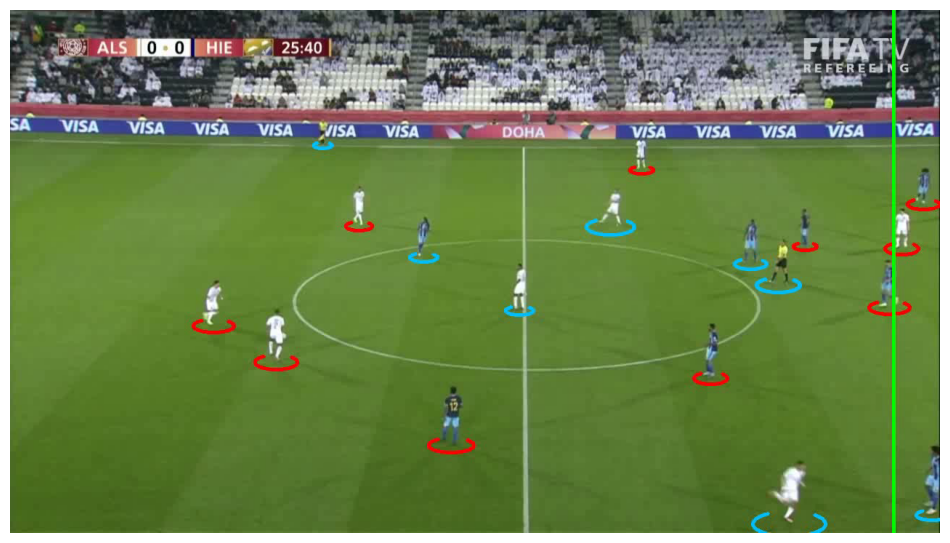

In [ ]:
frame_generator = sv.get_video_frames_generator(OUTPUT_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [ ]:
# # Initialize tracker
# tracker = sv.ByteTrack()
# tracker.reset()

# # Player tracking data
# player_positions = {}  # {tracker_id: [(x, y)]}
# player_distances = {}  # {tracker_id: total_distance}
# pixel_to_meter = 0.02  # Adjust based on actual field dimensions

# def measure_distance(p1, p2):
#     """Calculate Euclidean distance between two points."""
#     return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# # Process video frame by frame
# while True:
#     ret, frame = video.read()

#     if not ret or frame is None:
#         print("Warning: Empty frame detected. Stopping processing.")
#         break

#     try:
#         # Perform detection
#         result = detection_model.infer(frame, confidence=0.3)[0]
#         detections = sv.Detections.from_inference(result)
#     except Exception as e:
#         print(f"Error in model inference: {e}")
#         continue

#     # Separate ball detections
#     ball_detections = detections[detections.class_id == BALL_ID]
#     ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

#     # Process player detections with NMS and tracking
#     all_detections = detections[detections.class_id != BALL_ID]
#     all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
#     all_detections.class_id -= 1  # Adjust class IDs
#     all_detections = tracker.update_with_detections(detections=all_detections)

#     labels = []

#     # Update player speed and distance
#     if all_detections.tracker_id is not None:
#         for i, tracker_id in enumerate(all_detections.tracker_id):
#             x1, y1, x2, y2 = all_detections.xyxy[i]
#             center_x = (x1 + x2) / 2
#             center_y = (y1 + y2) / 2

#             if tracker_id not in player_positions:
#                 player_positions[tracker_id] = [(center_x, center_y)]
#                 player_distances[tracker_id] = 0.0
#             else:
#                 prev_x, prev_y = player_positions[tracker_id][-1]
#                 distance_pixels = measure_distance((prev_x, prev_y), (center_x, center_y))
#                 distance_meters = distance_pixels * pixel_to_meter
#                 player_distances[tracker_id] += distance_meters
#                 player_positions[tracker_id].append((center_x, center_y))

#                 # Calculate speed (distance/time)
#                 speed_mps = distance_meters * fps
#                 speed_kmh = speed_mps * 3.6

#                 cv2.putText(frame, f"{speed_kmh:.1f} km/h", (int(center_x), int(center_y) - 20),
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
#                 cv2.putText(frame, f"{player_distances[tracker_id]:.1f} m", (int(center_x), int(center_y) - 40),
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

#             labels.append(f"#{tracker_id}")

#     # Annotate the frame
#     try:
#         annotated_frame = frame.copy()
#         annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
#         annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
#         annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
#     except Exception as e:
#         print(f"Error during annotation: {e}")
#         continue

#     out.write(annotated_frame)

# # Release resources
# video.release()
# out.release()
# print("Annotated video saved at:", OUTPUT_VIDEO_PATH)